In [8]:
%load_ext autoreload
%autoreload 2

In [86]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import os
import sys
import pandas as pd
sys.path.insert(0, os.path.abspath('../'))

from keras.models import load_model
from scipy.stats import linregress, ranksums, ttest_ind, spearmanr, pearsonr

import sis as sis
import clustering
from rationale_objects import Rationale, BeerReview, BeerReviewContainer, \
                              SIS_RATIONALE_KEY, compute_mean_embedding

In [2]:
sis.tf_config(cuda_visible_devices='2')

In [3]:
figures_dir = '../figures/beer_asp1_aroma_cnn_vs_lstm'

In [244]:
ASPECT = 1

CNN_BRC_DIR = '../rationale_results/beer_reviews/asp%d_cnn' % ASPECT
LSTM_BRC_DIR = '../rationale_results/beer_reviews/asp%d' % ASPECT

CNN_TEST_BRC_DIR = '../rationale_results/beer_reviews/asp%d_test_cnn' % ASPECT
LSTM_TEST_BRC_DIR = '../rationale_results/beer_reviews/asp%d_test_lstm' % ASPECT

## Load Models

In [41]:
cnn_model_path = '../trained_models/asp%d_cnn.hdf5' % ASPECT

cnn_model = load_model(cnn_model_path,
                       custom_objects={'coeff_determination_metric': sis.coeff_determination_metric})

cnn_embed_model = sis.make_text_cnn_model_feed_embeddings()
sis.copy_layer_weights_text_cnn(cnn_model, cnn_embed_model)
print(cnn_embed_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 500, 100, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 498, 1, 128)       38528     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 38,657
Trainable params: 38,657
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
lstm_model_path = '../trained_models/asp%d_lstm.hdf5' % ASPECT

lstm_model = load_model(lstm_model_path,
                         custom_objects={'coeff_determination_metric': sis.coeff_determination_metric})

lstm_embed_model = sis.make_lstm_model_feed_embeddings()
sis.copy_layer_weights(lstm_model, lstm_embed_model)
print(lstm_embed_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 500, 200)          240800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 561,801
Trainable params: 561,801
Non-trainable params: 0
_________________________________________________________________
None


## Load SISes

In [9]:
cnn_brc = BeerReviewContainer.load_data(CNN_BRC_DIR)
lstm_brc = BeerReviewContainer.load_data(LSTM_BRC_DIR)

In [10]:
print('# Examples in CNN BRC:  %d' % len(cnn_brc))
print('# Examples in LSTM BRC: %d' % len(lstm_brc))
print('')
print('# Pos. Examples in CNN BRC:  %d' % len(cnn_brc.get_pos_reviews()))
print('# Pos. Examples in LSTM BRC: %d' % len(lstm_brc.get_pos_reviews()))

# Examples in CNN BRC:  284
# Examples in LSTM BRC: 337

# Pos. Examples in CNN BRC:  234
# Pos. Examples in LSTM BRC: 271


In [21]:
# Load embeddings from each model
# Also create copy where pad embedding uses the other model's
#   (for making predictions of SIS from one model on the other)

cnn_embeddings = np.copy(cnn_brc.embeddings)
lstm_embeddings = np.copy(lstm_brc.embeddings)

cnn_mean_embedding = compute_mean_embedding(cnn_embeddings)
lstm_mean_embedding = compute_mean_embedding(lstm_embeddings)

cnn_embeddings_with_lstm_pad = np.copy(cnn_embeddings)
cnn_embeddings_with_lstm_pad[0] = lstm_embeddings[0]
lstm_embeddings_with_cnn_pad = np.copy(lstm_embeddings)
lstm_embeddings_with_cnn_pad[0] = cnn_embeddings[0]

In [257]:
cnn_test_brc = BeerReviewContainer.load_data(CNN_TEST_BRC_DIR)
lstm_test_brc = BeerReviewContainer.load_data(LSTM_TEST_BRC_DIR) 

In [258]:
print('# Examples in CNN BRC:  %d' % len(cnn_test_brc))
print('# Examples in LSTM BRC: %d' % len(lstm_test_brc))
print('')
print('# Pos. Examples in CNN BRC:  %d' % len(cnn_test_brc.get_pos_reviews()))
print('# Pos. Examples in LSTM BRC: %d' % len(lstm_test_brc.get_pos_reviews()))

# Examples in CNN BRC:  2460
# Examples in LSTM BRC: 2900

# Pos. Examples in CNN BRC:  1521
# Pos. Examples in LSTM BRC: 1881


## Compare performance of the different models

In [ ]:
#  ( Num. Examples | MSE | Pearson r )

#### For CNN:
# Train & 70000 & 0.016 & 0.850  \\ 
# Validation & 3000 & 0.025 & 0.748  \\ 
# Test & 7000 & 0.026 & 0.741  \\ 
# Annotation & 994 & 0.014 & 0.662  \\ 

#### For LSTM:
# Train & 70000 & 0.014 & 0.873  \\ 
# Validation & 3000 & 0.024 & 0.767  \\ 
# Test & 7000 & 0.025 & 0.756  \\ 
# Annotation & 994 & 0.021 & 0.598  \\ 

## Predict on each model's SISes using other model

Looking at positive examples only. Use pad embedding and mean (replacement) embedding of whichever model is making the prediction.

Using test set for analysis (rather than annotation set), for larger # samples.

In [25]:
def get_all_sis_from_reviews(reviews, rationale_key=SIS_RATIONALE_KEY, replacement_embedding='mean',
                              embeddings=None):
    all_sis = []
    for review in reviews:
        rationales = review.get_rationales(rationale_key)
        for r in rationales:
            all_sis.append(
                review.get_embedded_sequence_rationale_only(
                    [r],
                    replacement_embedding=replacement_embedding,
                    embeddings=embeddings,
                )
            )
    return all_sis

In [259]:
all_lstm_test_sis_for_cnn = get_all_sis_from_reviews(lstm_test_brc.get_pos_reviews(), replacement_embedding=cnn_mean_embedding,
                                                 embeddings=cnn_embeddings)
all_lstm_test_sis_for_lstm = get_all_sis_from_reviews(lstm_test_brc.get_pos_reviews(), replacement_embedding=lstm_mean_embedding,
                                                 embeddings=lstm_embeddings)

all_cnn_test_sis_for_cnn = get_all_sis_from_reviews(cnn_test_brc.get_pos_reviews(), replacement_embedding=cnn_mean_embedding,
                                                 embeddings=cnn_embeddings)
all_cnn_test_sis_for_lstm = get_all_sis_from_reviews(cnn_test_brc.get_pos_reviews(), replacement_embedding=lstm_mean_embedding,
                                                 embeddings=lstm_embeddings)

In [260]:
lstm_test_sis_preds_by_lstm = sis.predict_for_embed_sequence(all_lstm_test_sis_for_lstm, lstm_embed_model)
lstm_test_sis_preds_by_cnn = sis.predict_for_embed_sequence(all_lstm_test_sis_for_cnn, cnn_embed_model)

cnn_test_sis_preds_by_cnn = sis.predict_for_embed_sequence(all_cnn_test_sis_for_cnn, cnn_embed_model)
cnn_test_sis_preds_by_lstm = sis.predict_for_embed_sequence(all_cnn_test_sis_for_lstm, lstm_embed_model)

assert(np.all(cnn_test_sis_preds_by_cnn) >= 0.85)
assert(np.all(lstm_test_sis_preds_by_lstm) >= 0.85)

In [278]:
columns = ['method', 'predictions']

preds_by_other_model_test_df = pd.DataFrame.from_dict({'LSTM SIS Preds by LSTM': lstm_test_sis_preds_by_lstm,
                                                       'CNN SIS Preds by CNN': cnn_test_sis_preds_by_cnn,
                                                       'CNN SIS Preds by LSTM': cnn_test_sis_preds_by_lstm,
                                                       'LSTM SIS Preds by CNN': lstm_test_sis_preds_by_cnn,},
                                                      orient='index').transpose()

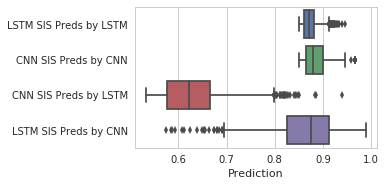

In [282]:
plt.figure(figsize=(5.5, 2.75))
sns.boxplot(data=preds_by_other_model_test_df, orient='h', order=[
    'LSTM SIS Preds by LSTM',
    'CNN SIS Preds by CNN',
    'CNN SIS Preds by LSTM',
    'LSTM SIS Preds by CNN'],
            palette=sns.color_palette())
plt.xlabel('Prediction')
# plt.title('SIS Predictions (pos. examples only, Aroma aspect)')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'sis_preds_by_other_models_aroma_test_set.png'), dpi=200, bbox_inches='tight')
plt.show()

## Joint Clustering of SISes from both models

In [327]:
all_lstm_test_sis_tokenized = clustering.text_get_all_sis_tokenized(lstm_test_brc.get_pos_reviews())
all_cnn_test_sis_tokenized = clustering.text_get_all_sis_tokenized(cnn_test_brc.get_pos_reviews())

all_test_sis_tokenized_combined = all_lstm_test_sis_tokenized + all_cnn_test_sis_tokenized
combined_test_dist_matrix = clustering.compute_jaccard_dist_matrix(all_test_sis_tokenized_combined)

In [328]:
print('Dist Matrix Median: ', np.median(combined_test_dist_matrix[combined_test_dist_matrix != 1.0]))

Dist Matrix Median:  0.8571428571428572


In [329]:
cluster_to_core_idxs, cluster_to_noncore_idxs, labels = clustering.cluster(
    combined_test_dist_matrix,
    eps=0.5,
    min_samples=20,
    verbose=True,
)

cluster_label_to_cluster = clustering.get_label_to_cluster(labels)

Estimated number of clusters: 13
# core samples:  1171


In [539]:
# Look at cluster composition from each model

count_lstm_test_idxs = lambda idxs: sum((1 for i in idxs if i < len(all_lstm_test_sis_tokenized)))

cluster_to_percent_models = []
cluser_composition_str_dict = {}

for cluster_num, cluster in sorted(cluster_label_to_cluster.items()):
    cluster_num_str = 'C' + str(cluster_num)
    num_lstm_idxs = count_lstm_test_idxs(cluster)
    num_cnn_idxs = len(cluster) - num_lstm_idxs
    perc_lstm = float(num_lstm_idxs) / len(cluster) * 100.0
    perc_cnn = float(num_cnn_idxs) / len(cluster) * 100.0
    cluster_to_percent_models.append((cluster_num, perc_lstm, perc_cnn))
    cluser_composition_str_dict[cluster_num] = '%d%%' % (np.around(perc_lstm))  # will show % LSTM
    print('Cluster %s (size=%d):  %.1f%% LSTM  /  %.1f%% CNN' % \
            (str(cluster_num_str), len(cluster), perc_lstm, perc_cnn))

Cluster C-1 (size=4001):  59.4% LSTM  /  40.6% CNN
Cluster C0 (size=119):  20.2% LSTM  /  79.8% CNN
Cluster C1 (size=1191):  21.0% LSTM  /  79.0% CNN
Cluster C2 (size=81):  46.9% LSTM  /  53.1% CNN
Cluster C3 (size=44):  4.5% LSTM  /  95.5% CNN
Cluster C4 (size=6):  33.3% LSTM  /  66.7% CNN
Cluster C5 (size=20):  5.0% LSTM  /  95.0% CNN
Cluster C6 (size=33):  24.2% LSTM  /  75.8% CNN
Cluster C7 (size=22):  4.5% LSTM  /  95.5% CNN
Cluster C8 (size=25):  40.0% LSTM  /  60.0% CNN
Cluster C9 (size=20):  0.0% LSTM  /  100.0% CNN
Cluster C10 (size=56):  0.0% LSTM  /  100.0% CNN
Cluster C11 (size=23):  0.0% LSTM  /  100.0% CNN
Cluster C12 (size=20):  70.0% LSTM  /  30.0% CNN


In [486]:
clusters_to_rationale_strs = clustering.get_all_rationale_strs_by_cluster(cluster_label_to_cluster,
                                  cluster_to_core_idxs,
                                  all_test_sis_tokenized_combined,
                                  lstm_test_brc.index_to_token,
)

assert(sum(len(v) for v in clusters_to_rationale_strs.values()) == combined_test_dist_matrix.shape[0])

In [396]:
clustering.text_print_clustering_by_freq(cluster_label_to_cluster,
                                          cluster_to_core_idxs,
                                          all_test_sis_tokenized_combined,
                                          lstm_test_brc.index_to_token,
                                          num_top=20)

-- Cluster -1 --
raspberries	16
lovely	15
delightful	15
brett	14
s big	14
very complex	13
s nice	10
decadent	9
leather	8
very inviting	8
allspice	7
promising	7
unbelievable	7
heaven	7
luscious	7
divine	6
nice smell	6
barley wine	5
complex nose	5
dreadnaught	5

-- Cluster 0 --
rich chocolate	13
very rich	9
chocolate complex	5
smells rich	4
so rich	3
bourbon chocolate	3
rich coffee	3
rich fruity	2
sweet rich	2
extremely rich	2
rich wine	2
complex rich	2
chocolate rich	2
chocolate bourbon	2
rich bourbon	2
perfect chocolate great excellent excellent	1
huge chocolate rich chocolate taste	1
thick aroma rich	1
rich molasses	1
aroma rich chocolate vanilla let regular	1

-- Cluster 1 --
great	248
amazing	119
wonderful	112
fantastic	75
awesome	62
incredible	46
beautiful	25
exceptional	23
bourbon vanilla	20
intoxicating	12
heavenly	12
terrific	11
sweet bourbon	9
phenomenal	9
bourbon oak	9
nice aroma	9
campfire	7
nice t	7
display	5
s huge	5

-- Cluster 2 --
best smelling	23
pineapple mango	6
mango

In [692]:
df = clustering.latex_table_text_clusters(cluster_label_to_cluster,
                                          cluster_to_core_idxs,
                                          all_test_sis_tokenized_combined,
                                          lstm_test_brc.index_to_token,
                                          num_sis=4,
                                          show_noise_cluster=False,
                                          include_freq=True,
                                          composition_data=cluser_composition_str_dict,
                                          composition_title='LSTM:')
df

,SIS 1,SIS 1 Freq,SIS 2,SIS 2 Freq,SIS 3,SIS 3 Freq,SIS 4,SIS 4 Freq
$C_{1}$ (LSTM: 20%),rich chocolate,13,very rich,9,chocolate complex,5,smells rich,4
$C_{2}$ (LSTM: 21%),great,248,amazing,119,wonderful,112,fantastic,75
$C_{3}$ (LSTM: 47%),best smelling,23,pineapple mango,6,mango pineapple,6,pineapple grapefruit,5
$C_{4}$ (LSTM: 5%),excellent,42,excellent flemish flemish,1,excellent excellent phenomenal,1,-,-
$C_{5}$ (LSTM: 33%),oak chocolate,2,chocolate raisins raisins oak bourbon,1,chocolate oak,1,raisins chocolate,1
$C_{6}$ (LSTM: 5%),goodness,19,watering goodness,1,-,-,-,-
$C_{7}$ (LSTM: 24%),pumpkin pie,25,huge pumpkin aroma pumpkin pie,1,aroma perfect pumpkin pie taste,1,smell pumpkin nutmeg cinnamon pie,1
$C_{8}$ (LSTM: 5%),jd,13,tremendous,8,tremendous jd,1,-,-
$C_{9}$ (LSTM: 40%),brulee,14,creme brulee brulee,3,creme creme,1,creme brulee amazing,1
$C_{10}$ (LSTM: 0%),s wow,20,-,-,-,-,-,-


Clustering examples with strong negative predicted sentiment (SISes from both models):

In [549]:
all_lstm_test_sis_tokenized_neg = clustering.text_get_all_sis_tokenized(lstm_test_brc.get_neg_reviews())
all_cnn_test_sis_tokenized_neg = clustering.text_get_all_sis_tokenized(cnn_test_brc.get_neg_reviews())

all_test_sis_tokenized_combined_neg = all_lstm_test_sis_tokenized_neg + all_cnn_test_sis_tokenized_neg
combined_test_dist_matrix_neg = clustering.compute_jaccard_dist_matrix(all_test_sis_tokenized_combined_neg)

In [550]:
print('Dist Matrix Median (neg): ', np.median(combined_test_dist_matrix_neg[combined_test_dist_matrix_neg != 1.0]))

Dist Matrix Median (neg):  0.75


In [565]:
cluster_to_core_idxs_neg, cluster_to_noncore_idxs_neg, labels_neg = clustering.cluster(
    combined_test_dist_matrix_neg,
    eps=0.5,
    min_samples=25,
    verbose=True,
)

cluster_label_to_cluster_neg = clustering.get_label_to_cluster(labels_neg)

Estimated number of clusters: 9
# core samples:  1769


In [566]:
# Look at cluster composition from each model

count_lstm_test_idxs_neg = lambda idxs: sum((1 for i in idxs if i < len(all_lstm_test_sis_tokenized_neg)))

cluster_to_percent_models_neg = []
cluser_composition_str_dict_neg = {}

for cluster_num, cluster in sorted(cluster_label_to_cluster_neg.items()):
    cluster_num_str = 'C' + str(cluster_num)
    num_lstm_idxs = count_lstm_test_idxs_neg(cluster)
    num_cnn_idxs = len(cluster) - num_lstm_idxs
    perc_lstm = float(num_lstm_idxs) / len(cluster) * 100.0
    perc_cnn = float(num_cnn_idxs) / len(cluster) * 100.0
    cluster_to_percent_models_neg.append((cluster_num, perc_lstm, perc_cnn))
    cluser_composition_str_dict_neg[cluster_num] = '%d%%' % (np.around(perc_lstm))  # will show % LSTM
    print('Cluster %s (size=%d):  %.1f%% LSTM  /  %.1f%% CNN' % \
            (str(cluster_num_str), len(cluster), perc_lstm, perc_cnn))

Cluster C-1 (size=1766):  62.7% LSTM  /  37.3% CNN
Cluster C0 (size=2126):  29.3% LSTM  /  70.7% CNN
Cluster C1 (size=1):  100.0% LSTM  /  0.0% CNN
Cluster C2 (size=1):  100.0% LSTM  /  0.0% CNN
Cluster C3 (size=26):  61.5% LSTM  /  38.5% CNN
Cluster C4 (size=28):  21.4% LSTM  /  78.6% CNN
Cluster C5 (size=1):  100.0% LSTM  /  0.0% CNN
Cluster C6 (size=34):  2.9% LSTM  /  97.1% CNN
Cluster C7 (size=82):  0.0% LSTM  /  100.0% CNN
Cluster C8 (size=42):  0.0% LSTM  /  100.0% CNN


In [694]:
df_neg = clustering.latex_table_text_clusters(cluster_label_to_cluster_neg,
                                              cluster_to_core_idxs_neg,
                                              all_test_sis_tokenized_combined_neg,
                                              lstm_test_brc.index_to_token,
                                              num_sis=4,
                                              show_noise_cluster=False,
                                              include_freq=True,
                                              composition_data=cluser_composition_str_dict_neg,
                                              composition_title='LSTM:')
df_neg

,SIS 1,SIS 1 Freq,SIS 2,SIS 2 Freq,SIS 3,SIS 3 Freq,SIS 4,SIS 4 Freq
$C_{1}$ (LSTM: 29%),not,247,no,105,bad,104,macro,94
$C_{2}$ (LSTM: 100%),gross rotten,1,-,-,-,-,-,-
$C_{3}$ (LSTM: 100%),rotten garbage,1,-,-,-,-,-,-
$C_{4}$ (LSTM: 62%),vomit,26,-,-,-,-,-,-
$C_{5}$ (LSTM: 21%),budweiser,22,sewage budweiser,1,metal budweiser,1,budweiser budweiser budweiser,1
$C_{6}$ (LSTM: 100%),garbage rice,1,-,-,-,-,-,-
$C_{7}$ (LSTM: 3%),n't,19,adjuncts,14,n't adjuncts,1,-,-
$C_{8}$ (LSTM: 0%),faint,82,-,-,-,-,-,-
$C_{9}$ (LSTM: 0%),adjunct,42,-,-,-,-,-,-
